**Predicting the 2025/26 English Premier League Winner Using Machine Learning**

*Objective:*
To apply machine learning techniques to historical EPL match data to predict match outcomes, simulate the 2025/26 season, and forecast team standings, including total points and goal difference.

In [26]:
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import glob
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

The data used was found from https://www.football-data.co.uk/ . since the csv files were from different years, let's start by combining all the data

In [27]:
#Find Path of saved csv files
path = "/Users/dimphomola/Desktop/EPL Predictions"  

# Get all CSV files in the folder
files = glob.glob(os.path.join(path, "*.csv"))

print("Files found:", files)

Files found: ['/Users/dimphomola/Desktop/EPL Predictions/E0 (3).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (10).csv', '/Users/dimphomola/Desktop/EPL Predictions/EPL_Combined.csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (2).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0.csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (9).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (5).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (4).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (8).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (7).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (6).csv', '/Users/dimphomola/Desktop/EPL Predictions/E0 (1).csv']


In [28]:
## File to exclude
exclude_file = "EPL 25 Win.ipynb"   

# Filter the list
files_to_use = [f for f in files if not f.endswith(exclude_file)]

# Get all CSV files in the folder
all_files = glob.glob(os.path.join(path, "*.csv"))

# Optional: exclude a specific file if you don't want to combine it
exclude_file = os.path.join(path, "EPL_Combined.csv")
files_to_combine = [f for f in all_files if f != exclude_file]

# Read each CSV and store in a list
dfs = []
for file in files_to_combine:
    df = pd.read_csv(file)
    dfs.append(df)

# Combine all dataframes
epl_data = pd.concat(dfs, ignore_index=True)

# Save the combined file
output_file = os.path.join(path, "EPL_Combined.csv")
epl_data.to_csv(output_file, index=False)

print(f"Combined file saved at: {output_file}")
print(f"Shape of combined data: {epl_data.shape}")

Combined file saved at: /Users/dimphomola/Desktop/EPL Predictions/EPL_Combined.csv
Shape of combined data: (4181, 156)


Combined historical EPL match data from multiple seasons.
This dataset contains match info, goals scored, encoded teams, and other features.


In [29]:
# Load combined data
df = pd.read_csv("/Users/dimphomola/Desktop/EPL Predictions/EPL_Combined.csv")

/var/folders/t4/5srx21zj5fs7m5pchy7005dw0000gn/T/ipykernel_95181/730238876.py:2: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/dimphomola/Desktop/EPL Predictions/EPL_Combined.csv")


In [30]:
#Encode teams
le = LabelEncoder()
df['HomeTeamEncoded'] = le.fit_transform(df['HomeTeam'])
df['AwayTeamEncoded'] = le.transform(df['AwayTeam'])

 Machine learning models require numerical inputs. 
 We encode team names into integers to use as features.

In [31]:
# Calculate average goals for features
df['HomeGoalsAvg'] = df.groupby('HomeTeam')['FTHG'].transform('mean')
df['AwayGoalsAvg'] = df.groupby('AwayTeam')['FTAG'].transform('mean')

# Create target: 1 = Home win, 2 = Away win, 0 = Draw
df['Winner'] = df['FTR'].map({'H': 1, 'A': 2, 'D': 0})

In [32]:
# Drop rows with missing values
features = ['HomeGoalsAvg', 'AwayGoalsAvg', 'HomeTeamEncoded', 'AwayTeamEncoded']
target = 'Winner'
df.dropna(subset=features + [target], inplace=True)

Selected key features for predicting match outcomes and removed any incomplete rows to avoid errors.

In [33]:
#Train Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(df[features], df[target])

# Predict winner
df['PredictedWinnerLabel'] = model.predict(df[features])

# Check results
print(df[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'PredictedWinnerLabel']].head())

         Date        HomeTeam      AwayTeam FTR  PredictedWinnerLabel
0  11/08/2017         Arsenal     Leicester   H                   1.0
1  12/08/2017        Brighton      Man City   A                   2.0
2  12/08/2017         Chelsea       Burnley   A                   0.0
3  12/08/2017  Crystal Palace  Huddersfield   A                   1.0
4  12/08/2017         Everton         Stoke   H                   1.0


Model predicts whether home team wins, away team wins, or a draw.

In [70]:
## Initialize a dictionary to store points per team
teams = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel())
points = {team: 0 for team in teams}

# Assign points based on predicted results
for _, row in df.iterrows():
    home = row['HomeTeam']
    away = row['AwayTeam']
    pred = row['PredictedWinnerLabel']
    
    if pred == 1:        # Home win
        points[home] += 3
    elif pred == 2:      # Away win
        points[away] += 3
    else:                # Draw
        points[home] += 1
        points[away] += 1

# Create DataFrame and sort
league_table = pd.DataFrame(list(points.items()), columns=['Team', 'PredictedPoints'])
league_table = league_table.sort_values(by='PredictedPoints', ascending=False).reset_index(drop=True)

# Display top teams
print(league_table.head(10))

         Team  PredictedPoints
0    Man City             1178
1   Liverpool             1043
2     Arsenal              937
3     Chelsea              872
4   Tottenham              854
5  Man United              834
6     Everton              617
7   Newcastle              582
8    West Ham              554
9   Leicester              451


This loop helps simulate the entire season, calculating total points and goal difference.

In [77]:
# Make sure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter only 2025/26 season
df_2526 = df[df['Date'].dt.year == 2025]

# Initialize points and goal difference dictionary
teams = pd.concat([df_2526['HomeTeam'], df_2526['AwayTeam']]).unique()
points_dict = {team: 0 for team in teams}
gd_dict = {team: 0 for team in teams}

In [78]:
# Assign points based on PredictedWinnerLabel and compute goal difference
for _, row in df_2526.iterrows():
    home = row['HomeTeam']
    away = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    pred = row['PredictedWinnerLabel']

    # Update points
    if pred == 1:  # Home win
        points_dict[home] += 3
    elif pred == 2:  # Away win
        points_dict[away] += 3
    else:  # Draw
        points_dict[home] += 1
        points_dict[away] += 1

    # Update goal difference
    gd_dict[home] += home_goals - away_goals
    gd_dict[away] += away_goals - home_goals

In [81]:
# Create final table
predicted_table_2526 = pd.DataFrame({
    'Team': list(points_dict.keys()),
    'PredictedPoints': list(points_dict.values()),
    'GoalDifference': list(gd_dict.values())
})

# Sort by points and goal difference
predicted_table_2526 = predicted_table_2526.sort_values(
    by=['PredictedPoints', 'GoalDifference'], ascending=False
).reset_index(drop=True)

# Display top 10 teams
top10_2526 = predicted_table_2526.head(10)
print(top10_2526)

         Team  PredictedPoints  GoalDifference
0    Man City               54            22.0
1   Liverpool               51            17.0
2     Arsenal               43            16.0
3   Newcastle               40            10.0
4     Chelsea               40             6.0
5   Tottenham               38           -14.0
6  Man United               36            -5.0
7   Brentford               29             9.0
8      Wolves               27            -4.0
9     Everton               26             7.0


The final predicted standings show which team is expected to win the 2025/26 EPL season

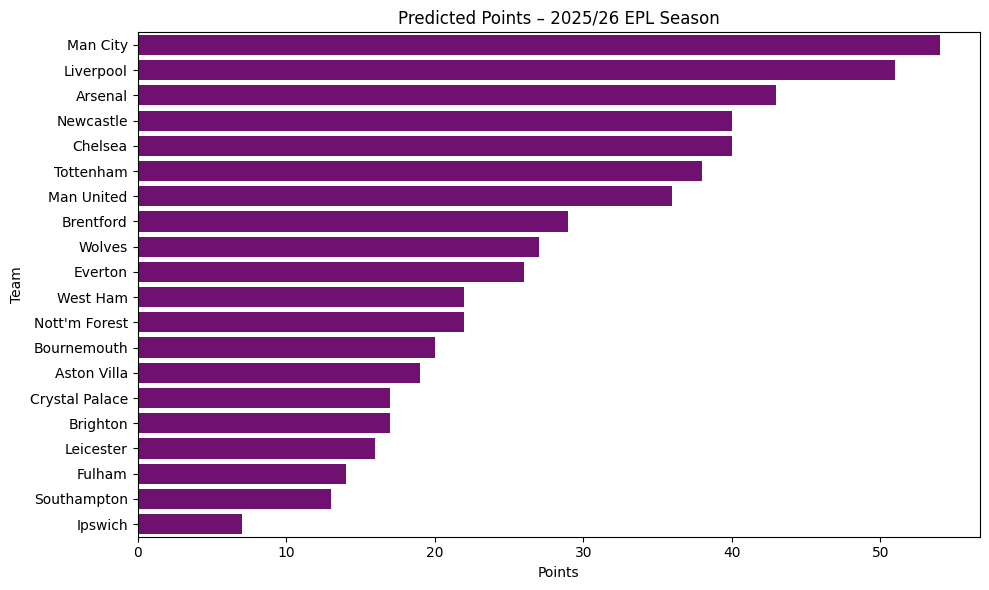

In [89]:
#Plot Point difference on a histogram 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
predicted_table_2526_sorted = predicted_table_2526.sort_values('PredictedPoints', ascending=False)

# Create horizontal bar plot
sns.barplot(
    x='PredictedPoints', 
    y='Team', 
    data=predicted_table_2526_sorted, 
    color='purple'  # Set the color here
)
plt.title('Predicted Points – 2025/26 EPL Season')
plt.xlabel('Points')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

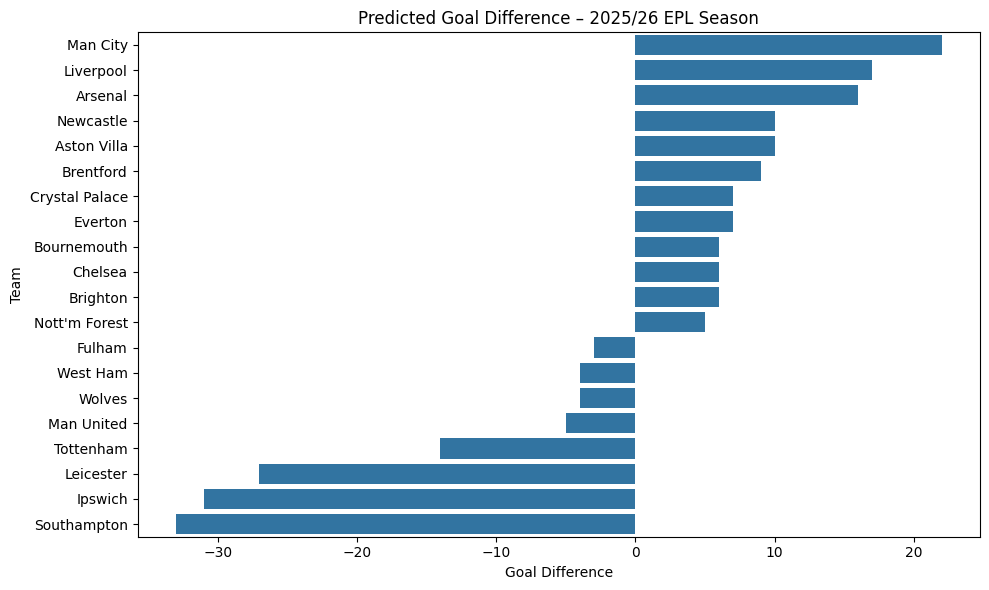

In [94]:
plt.figure(figsize=(10,6))

sns.barplot(x='GoalDifference', y='Team', data=predicted_table_2526.sort_values('GoalDifference', ascending=False))
plt.title('Predicted Goal Difference – 2025/26 EPL Season')
plt.xlabel('Goal Difference')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

In this project, we used historical EPL data to build a machine learning model that predicts match outcomes for the 2025/26 season. From these predictions, we calculated each team’s expected points and goal difference to simulate the league table for the upcoming season.

This project demonstrates how we can leverage data and predictive modeling to forecast sports outcomes. It also highlights our ability to clean data, handle missing values, and combine metrics to generate actionable insights. The results give a clear view of which teams might compete at the top in 2025/26 and provide a foundation for further analysis.